# Exercise 8-2: Collaborative Filtering

In this part of the exercise, we will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings.

## Part 1: Loading movie ratings dataset

The `ex8_movies.mat` contains the ratings of 1682 movies on 943 users.

Average rating for movie 1 (Toy Story): 3.87831858407 / 5


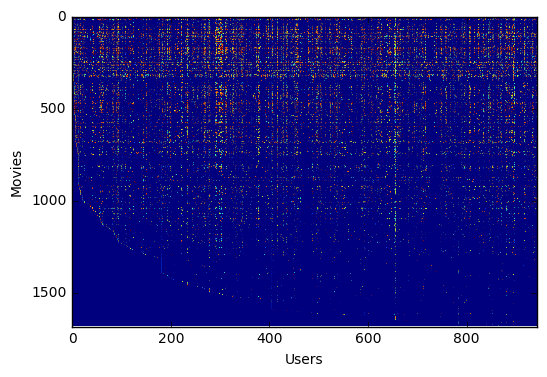

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt


mat_data = sio.loadmat('ex8_movies.mat')

# Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies on 943 users
Y = mat_data['Y']

# R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a rating to movie i
R = mat_data['R']

print 'Average rating for movie 1 (Toy Story): {} / 5'.format(np.mean(Y[0, np.nonzero(R[0, ])]))

# We can "visualize" the ratings matrix by plotting it with imshow
plt.figure()
plt.imshow(Y, aspect='auto')
plt.ylabel('Movies')
plt.xlabel('Users')
plt.show()

## Part 2: Collaborative Filtering Cost Function 

The `cofi_cost_func()` computes the cost and gradient for the collaborative filtering problem.

In [2]:
def cofi_cost_func(params, Y, R, num_users, num_movies, num_features, l):
    """
    Returns the cost and gradient for the collaborative filtering problem.

    Parameters
    ----------
    params : ndarray, shape ((num_users + num_movies) * num_features,)
        Parameters for collaborative filtering.
    Y : ndarray, shape (num_movies, num_users)
        Ratings, where n_movies is the number of movies and n_users is the number of users.
    R : ndarray, shape (num_movies, num_users)
        R(i,j) = 1 if and only if user j gave a rating to movie i.
    num_users : int
        Number of users.
    num_movies : int
        Number of movies.
    num_features : int
        Number of features.
    l : float, shape ((num_users + num_movies) * num_features,)
        Regularization parameter.

    Returns
    -------
    J : numpy.float64
        The cost for collaborative filtering.
    grad : ndarray, shape ((num_users + num_movies) * num_features,)
        The gradient for collaborative filtering.
    """
    X = params[0:num_movies*num_features].reshape((num_movies, num_features))
    Theta = params[num_movies*num_features: ].reshape((num_users, num_features))

    J = 0.5 * np.sum(np.sum(R * np.square(X.dot(Theta.T) - Y)))
    X_grad = (R * (X.dot(Theta.T) - Y)).dot(Theta)
    Theta_grad = (R * (X.dot(Theta.T) - Y)).T.dot(X)

    J = J + 0.5 * l * np.sum(np.square(Theta)) + 0.5 * l * np.sum(np.square(X))
    X_grad = X_grad + l * X
    Theta_grad = Theta_grad + l * Theta

    grad = np.hstack((X_grad.ravel(), Theta_grad.ravel()))

    return J, grad

Load pre-trained weights from `ex8_movieParams.mat` and calculate the cost and gradient for the collaborative filtering:

In [3]:
mat_data = sio.loadmat('ex8_movieParams.mat')
X = mat_data['X']
Theta = mat_data['Theta']
num_users = mat_data['num_users'].ravel()[0]
num_movies = mat_data['num_movies'].ravel()[0]
num_features = mat_data['num_features'].ravel()[0]

# Reduce the data set size so that this runs faster
num_users = 4
num_movies = 5
num_features = 3
X = X[0:num_movies, 0:num_features]
Theta = Theta[0:num_users, 0:num_features]
Y = Y[0:num_movies, 0:num_users]
R = R[0:num_movies, 0:num_users]

J, grad = cofi_cost_func(np.hstack((X.flatten(), Theta.flatten())), Y, R, num_users, num_movies, num_features, 0)
print 'Cost at loaded parameters:', J
print '(this value should be about 22.22)'

Cost at loaded parameters: 22.2246037257
(this value should be about 22.22)


## Part 3: Collaborative Filtering Cost Regularization

Evaluate the cost function with regularization:

In [4]:
J, grad = cofi_cost_func(np.hstack((X.flatten(), Theta.flatten())), Y, R, num_users, num_movies, num_features, 1.5)
print 'Cost at loaded parameters (lambda = 1.5):', J
print '(this value should be about 31.34)'

Cost at loaded parameters (lambda = 1.5): 31.3440562443
(this value should be about 31.34)


## Part 4: Entering ratings for a new user

The `load_movie_list()` loads movie list from `movie_ids.txt`. Rate some of the movies as new user ratings:

In [5]:
from load_movie_list import load_movie_list


movie_list = load_movie_list()

# Initialize my ratings
my_ratings = np.zeros(len(movie_list), dtype=np.int)
my_ratings[0] = 4
my_ratings[97] = 2
my_ratings[6] = 3
my_ratings[11] = 5
my_ratings[53] = 4
my_ratings[63] = 5
my_ratings[65] = 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

print 'New user ratings:'
for i in np.argwhere(my_ratings > 0).ravel():
    print 'Rated {} for {}'.format(my_ratings[i], movie_list[i])

New user ratings:
Rated 4 for Toy Story (1995)
Rated 3 for Twelve Monkeys (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for Outbreak (1995)
Rated 5 for Shawshank Redemption, The (1994)
Rated 3 for While You Were Sleeping (1995)
Rated 5 for Forrest Gump (1994)
Rated 2 for Silence of the Lambs, The (1991)
Rated 4 for Alien (1979)
Rated 5 for Die Hard 2 (1990)
Rated 5 for Sphere (1998)


## Part 5: Learning Movie Ratings

The `normalize_ratings()` normalizes the ratings by subtracting mean rating for every movie.

In [6]:
def normalize_ratings(Y, R):
    """
    Preprocess data by subtracting mean rating for every movie (every row).

    Parameters
    ----------
    Y : ndarray, shape (n_movies, n_users)
        Ratings, where n_movies is the number of movies and n_users is the number of users.
    R : ndarray, shape (n_samples, n_users)
        R(i,j) = 1 if and only if user j gave a rating to movie i.

    Returns
    -------
    Y_norm : ndarray, shape (n_movies, n_users)
        Normalized Y with each movie has am average rating of 0.
    Y_mean : ndarray, shape (n_movies, 1)
        Mean rating for each movie.
    """
    m = Y.shape[0]
    Y_mean = np.zeros(m)
    Y_norm = np.zeros(Y.shape)

    for i in range(m):
        idx = np.nonzero(R[i, ] == 1)
        Y_mean[i] = np.mean(Y[i, idx])
        Y_norm[i, idx] = Y[i, idx] - Y_mean[i]

    return Y_norm, Y_mean

Train collaborative filtering and learn the parameters X and Theta:

In [7]:
import scipy.optimize as opt


mat_data = sio.loadmat('ex8_movies.mat')

# Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies on 943 users
Y = mat_data['Y']
# R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a rating to movie i
R = mat_data['R']

# Add our own ratings to the data matrix
Y = np.hstack((my_ratings.reshape(len(movie_list), 1), Y))
R = np.hstack((my_ratings.reshape(len(movie_list), 1) != 0, R))

# Normalize Ratings
Y_norm, Y_mean = normalize_ratings(Y, R)

# Useful Values
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10

# Set Initial Parameters (Theta, X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters = np.hstack((X.flatten(), Theta.flatten()))

# Set Regularization
l = 10
result = opt.minimize(fun=cofi_cost_func, x0=initial_parameters,
                      args=(Y_norm, R, num_users, num_movies, num_features, l),
                      method='CG', jac=True, options={'maxiter': 150})

X = result.x[0:num_movies * num_features].reshape((num_movies, num_features))
Theta = result.x[num_movies * num_features:].reshape((num_users, num_features))

print 'Recommender system learning completed.'

Recommender system learning completed.


## Part 8: Recommendation for you

With X and Theta we can computes the ratings for all the movies and users. Pick the ratings of the "new user" we've added in part 4 and display the top rating movies for the "new user":

In [8]:
p = X.dot(Theta.T)
my_predictions = p[:, 0] + Y_mean
idx = np.argsort(my_predictions)[::-1]
print 'Top recommendations for you:'
for i in range(10):
    print 'Predicting rating {0:.1f} for movie {1:s}'.format(my_predictions[idx[i]], movie_list[idx[i]])

print '\nOriginal ratings provided:'
for i in np.argwhere(my_ratings > 0).ravel():
    print 'Rated {} for {}'.format(my_ratings[i], movie_list[i])

Top recommendations for you:
Predicting rating 5.0 for movie Great Day in Harlem, A (1994)
Predicting rating 5.0 for movie Prefontaine (1997)
Predicting rating 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 5.0 for movie Someone Else's America (1995)
Predicting rating 5.0 for movie They Made Me a Criminal (1939)
Predicting rating 5.0 for movie Saint of Fort Washington, The (1993)
Predicting rating 5.0 for movie Aiqing wansui (1994)
Predicting rating 5.0 for movie Star Kid (1997)
Predicting rating 5.0 for movie Marlene Dietrich: Shadow and Light (1996)
Predicting rating 5.0 for movie Santa with Muscles (1996)

Original ratings provided:
Rated 4 for Toy Story (1995)
Rated 3 for Twelve Monkeys (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for Outbreak (1995)
Rated 5 for Shawshank Redemption, The (1994)
Rated 3 for While You Were Sleeping (1995)
Rated 5 for Forrest Gump (1994)
Rated 2 for Silence of the Lambs, The (1991)
Rated 4 for Alien (1979)
R